# Import the libraries

In [1]:
import pandas as pd
from linearmodels import PanelOLS
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Set the font to Times New Roman
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = 'Times New Roman'

# Prepare the data

In [2]:
ind_col = 'naicsh6'
nlp_model = 'mpnet'
doc2vec_vector_size = 768 # 768 for mpnet, 1536 for ada

data = pd.read_pickle(f'../data/all_reg_vars_{nlp_model}_{str(doc2vec_vector_size)}_{ind_col}.pkl')
data.replace([np.inf, -np.inf], np.nan, inplace=True)


### Create lead variables for the DVs

In [3]:
# Sort data by GVKEY and year
reg_data = data.sort_values(by=['GVKEY', 'year'])
# Lead dependent variables by one year
reg_data['numrec_mean_0_lead'] = reg_data.groupby('GVKEY')['numrec_mean_0'].shift(-1)
reg_data['meanrec_mean_descend_lead'] = reg_data.groupby('GVKEY')['meanrec_mean_descend'].shift(-1)
reg_data['year_lead'] = reg_data.groupby('GVKEY')['year'].shift(-1)
reg_data['year_diff'] = reg_data['year_lead'] - reg_data['year']
reg_data = reg_data[reg_data['year_diff'] <=2 ]
reg_data['constant'] = 1

In [4]:
# Limit the data to non-exemplar firms and industries with at least 10 firms
reg_data = reg_data[(reg_data[f'exemplar_{ind_col}'] == 0) & (reg_data[f'no_firms_{ind_col}'] > 9)]

In [5]:
reg_data['year_lead'] = reg_data.groupby('GVKEY')['year'].shift(-1)


### Rename the variables to make them more readable

In [6]:
# define a dictionary that maps old names to new names
rename_dict = {
    'numrec_mean_0_lead': 'Analyst Coverage',
    'meanrec_mean_descend_lead': 'Analyst Recoms',
    f'exemplar_sim_{ind_col}': 'Exemplar Similarity',
    'sale_wins_1': 'Total Sales',
    'n_emp': 'Firm Size',
    'EPS_wins_1': 'EPS',
    'slack_avail_wins_1': 'Available Slack',
    'rd_f_wins_1': 'R&D Expenditure',
    'adv_f_wins_1': 'Advertising Expenditure',
    'dpt_f_wins_1': 'Depreciation Ratio',
    'intang_f_wins_1': 'Intangible Assets Ratio',
    'n_segments': 'No. Segments',
    f'market_share_{ind_col}': 'Market Share',
    'mergers_wins_1': 'Mergers (expenditure)',
    'leverage_wins_1': 'Financial Leverage',
    'is_spx500': 'S&P500 Dummy',
    f'sim_mean_{ind_col}': 'Firm Typicality',
    'strong_weak_modal_ratio': 'Strong-Weak Modals Ratio',
    'positive_negative_ratio': 'Positive-Negative Words Ratio',
    'N_Litigious': 'Litigous Words Ratio',
    f'n_analysts_{ind_col}': 'No. Analysts in Industry',
    f'no_firms_{ind_col}': 'No. Firms in Industry',
    f'category_coherence_{ind_col}': 'Category Coherence',
    f'numrec_avg_year_{ind_col}': 'Average Coverage (Year-Ind)',
    f'meanrec_avg_year_{ind_col}': 'Average Recoms (Year-Ind)',
    f'ind_sim_all_{ind_col}_distinct': 'Category Distinctiveness',
    f'ind_vecs_change_{ind_col}': 'Category Instability',
    f'hhi_{ind_col}': 'Industry HHI',
    f'EPS_wins_1_ex_{ind_col}': 'Exemplar EPS',
    f'exemplar_{ind_col}_typicality': 'Exemplar Typicality',
    'constant': 'Constant'
}

# rename columns
reg_data = reg_data.rename(columns=rename_dict)


### Define the list of independent/control variables


In [7]:
iv = ['Exemplar Similarity']
moderators = ['Category Coherence', 'Category Distinctiveness','Exemplar Typicality']
controls = [
            'Total Sales', 'Firm Size','Market Share', 'EPS', 'Available Slack', 'R&D Expenditure',
            'Advertising Expenditure', 'Intangible Assets Ratio', 'Depreciation Ratio', 
            'Firm Typicality',  'No. Segments',
             'Mergers (expenditure)', 'Financial Leverage', 'S&P500 Dummy', 
             'No. Analysts in Industry', 'No. Firms in Industry',  
             'Average Coverage (Year-Ind)', 'Average Recoms (Year-Ind)',
             'Category Instability', 'Industry HHI', 'Exemplar EPS',
             'Constant']
dv = ['Analyst Coverage', 'Analyst Recoms']

In [8]:
# Set index to GVKEY and year
reg_data = reg_data.set_index(['GVKEY', 'year'])

# Descriptive statistics

In [9]:
all_vars = dv + iv + moderators + controls
all_vars.remove('Constant')

In [10]:
desc_stats = reg_data[all_vars].describe().loc[['count', 'mean', 'std', 'min', 'max']]


In [11]:
desc_stats

,Analyst Coverage,Analyst Recoms,Exemplar Similarity,Category Coherence,Category Distinctiveness,Exemplar Typicality,Total Sales,Firm Size,Market Share,EPS,...,Mergers (expenditure),Financial Leverage,S&P500 Dummy,No. Analysts in Industry,No. Firms in Industry,Average Coverage (Year-Ind),Average Recoms (Year-Ind),Category Instability,Industry HHI,Exemplar EPS
count,81763.00000,46379.000000,49521.000000,81739.000000,81717.000000,49521.000000,77982.000000,74560.000000,77907.000000,77865.000000,...,81763.000000,77763.000000,81763.000000,81095.000000,81763.000000,80171.000000,80171.000000,80705.000000,81763.000000,49442.000000
mean,3.59206,3.721379,0.865626,0.906513,-0.796637,0.931472,1907.656426,6.815623,0.022911,0.577350,...,-0.889251,0.880375,0.051478,142.183119,137.980920,7.303893,3.766441,0.005957,0.184691,1.573028
std,5.02855,0.585404,0.086916,0.032538,0.071882,0.044518,6534.649299,34.281737,0.065144,2.143502,...,5.290541,2.151855,0.220972,129.510885,150.979213,3.426670,0.313991,0.012428,0.200357,2.686293
min,0.00000,1.000000,0.156085,0.754958,-0.932581,0.615340,0.000000,0.000000,-0.073177,-7.034867,...,-48.000000,-6.991323,0.000000,1.000000,10.000000,1.000000,2.000000,0.000121,0.000000,-7.034867
max,50.00000,5.000000,1.000000,1.000000,-0.542157,0.992007,51245.617320,2545.209000,1.000000,9.955915,...,2.291000,14.655649,1.000000,751.000000,609.000000,29.428571,5.000000,0.163246,1.000000,9.955915


In [12]:
desc_stats.to_csv(f'../data/tables/descriptives.csv')

## Bivariate correlations

In [13]:
corr_matrix = reg_data[all_vars].corr()

In [14]:
# Mask upper triangle excluding the diagonal
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
corr_matrix.mask(mask, inplace=True)

In [15]:
# Rename the columns and index
corr_matrix.columns = [f'({i+1})' for i in range(len(corr_matrix.columns))]
corr_matrix.index = [f'({i+1}) {idx}' for i, idx in enumerate(corr_matrix.index)]

In [16]:
corr_matrix

,(1),(2),(3),(4),(5),(6),(7),(8),(9),(10),...,(18),(19),(20),(21),(22),(23),(24),(25),(26),(27)
(1) Analyst Coverage,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
(2) Analyst Recoms,-0.093226,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
(3) Exemplar Similarity,0.074662,-0.083484,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
(4) Category Coherence,0.006082,-0.120380,0.569496,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
(5) Category Distinctiveness,-0.039118,0.163659,0.140534,0.037722,1.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
(6) Exemplar Typicality,0.015608,-0.062737,0.617846,0.598716,0.164650,1.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
(7) Total Sales,0.177658,-0.056120,0.012418,0.085796,-0.040950,0.012534,1.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
(8) Firm Size,0.110819,-0.040626,-0.014081,0.052276,-0.041924,-0.008805,0.555343,1.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
(9) Market Share,0.150430,-0.039115,-0.105476,0.000760,-0.102951,-0.096411,0.460347,0.360061,1.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
(10) EPS,0.160488,-0.092171,0.033420,0.119621,-0.192466,0.027570,0.235996,0.129669,0.163948,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
corr_matrix.to_csv(f'../data/tables/correlations.csv')

## VIF tests

In [18]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [19]:

def calculate_vif(df):
    df_const = add_constant(df)
    vif_df = pd.DataFrame()
    vif_df["variables"] = df_const.columns
    vif_df["VIF"] = [variance_inflation_factor(df_const.values, i) for i in range(df_const.shape[1])]
    return vif_df[vif_df['variables'] != 'Constant'] 


In [20]:
regressors = iv + moderators + controls
reg_data_vif = reg_data.replace([np.inf, -np.inf], np.nan).dropna(subset=regressors)


In [21]:
vif = calculate_vif(reg_data_vif[regressors])
print(vif)
print('mean VIF: ', vif['VIF'].mean())


                      variables       VIF
0           Exemplar Similarity  3.947322
1            Category Coherence  2.534481
2      Category Distinctiveness  2.430413
3           Exemplar Typicality  2.032240
4                   Total Sales  1.929524
5                     Firm Size  1.350824
6                  Market Share  1.567772
7                           EPS  1.306947
8               Available Slack  1.601043
9               R&D Expenditure  2.603267
10      Advertising Expenditure  1.066805
11      Intangible Assets Ratio  1.345107
12           Depreciation Ratio  1.306477
13              Firm Typicality  2.747327
14                 No. Segments  1.230674
15        Mergers (expenditure)  1.121143
16           Financial Leverage  1.070467
17                 S&P500 Dummy  1.518499
18     No. Analysts in Industry  2.875968
19        No. Firms in Industry  3.289003
20  Average Coverage (Year-Ind)  1.349682
21    Average Recoms (Year-Ind)  1.353928
22         Category Instability  1

# Regression Models

## Effect of Exemplar similarity on Analyst Coverage

In [22]:
regressors = iv + moderators + controls
model1 = PanelOLS(reg_data['Analyst Coverage'], reg_data[regressors], entity_effects=True)
res1 = model1.fit(cov_type='clustered', cluster_entity=True)
res1


Dep. Variable:,Analyst Coverage,R-squared:,0.1184
Estimator:,PanelOLS,R-squared (Between):,0.2009
No. Observations:,46786,R-squared (Within):,0.1184
Date:,"Tue, Jun 20 2023",R-squared (Overall):,0.1778
Time:,13:04:08,Log-likelihood,-1.06e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,210.39
Entities:,7603,P-value,0.0000
Avg Obs:,6.1536,Distribution:,"F(25,39158)"
Min Obs:,1.0000,,
Max Obs:,25.000,F-statistic (robust):,33.280


## Effect of Exemplar Similarity on Analyst Recommendations

In [23]:
regressors = iv + moderators + controls
model2 = PanelOLS(reg_data['Analyst Recoms'], reg_data[regressors], entity_effects=True)
res2 = model2.fit(cov_type='clustered', cluster_entity=True)
res2

Dep. Variable:,Analyst Recoms,R-squared:,0.0526
Estimator:,PanelOLS,R-squared (Between):,0.0295
No. Observations:,30688,R-squared (Within):,0.0526
Date:,"Tue, Jun 20 2023",R-squared (Overall):,0.0409
Time:,13:04:08,Log-likelihood,-1.268e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,54.799
Entities:,5975,P-value,0.0000
Avg Obs:,5.1361,Distribution:,"F(25,24688)"
Min Obs:,1.0000,,
Max Obs:,25.000,F-statistic (robust):,28.138


## Moderation Effect of Category Coherence

In [24]:
# Regressions with interaction terms - analyst coverage and category coherence
interaction_term = 'Exemplar Similarity x Category Coherence'
reg_data[interaction_term] = reg_data['Exemplar Similarity'] * reg_data['Category Coherence']
regressors = iv + moderators + [interaction_term] + controls

model3 = PanelOLS(reg_data['Analyst Coverage'], reg_data[regressors], entity_effects=True)
res3 = model3.fit(cov_type='clustered', cluster_entity=True)
res3


Dep. Variable:,Analyst Coverage,R-squared:,0.1215
Estimator:,PanelOLS,R-squared (Between):,0.1938
No. Observations:,46786,R-squared (Within):,0.1215
Date:,"Tue, Jun 20 2023",R-squared (Overall):,0.1702
Time:,13:04:09,Log-likelihood,-1.059e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,208.36
Entities:,7603,P-value,0.0000
Avg Obs:,6.1536,Distribution:,"F(26,39157)"
Min Obs:,1.0000,,
Max Obs:,25.000,F-statistic (robust):,33.306


In [25]:
interaction_term = 'Exemplar Similarity x Category Coherence'
reg_data[interaction_term] = reg_data['Exemplar Similarity'] * reg_data['Category Coherence']
regressors = iv + moderators + [interaction_term] + controls

model4 = PanelOLS(reg_data['Analyst Recoms'], reg_data[regressors], entity_effects=True)
res4 = model4.fit(cov_type='clustered', cluster_entity=True)
res4

Dep. Variable:,Analyst Recoms,R-squared:,0.0529
Estimator:,PanelOLS,R-squared (Between):,0.0329
No. Observations:,30688,R-squared (Within):,0.0529
Date:,"Tue, Jun 20 2023",R-squared (Overall):,0.0453
Time:,13:04:09,Log-likelihood,-1.267e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,52.999
Entities:,5975,P-value,0.0000
Avg Obs:,5.1361,Distribution:,"F(26,24687)"
Min Obs:,1.0000,,
Max Obs:,25.000,F-statistic (robust):,27.618


## Moderation Effect of Category Distinctiveness

In [26]:
# Regressions with interaction terms - analyst coverage and category coherence
interaction_term = 'Exemplar Similarity x Category Distinctiveness'
reg_data[interaction_term] = reg_data['Exemplar Similarity'] * reg_data['Category Distinctiveness']
regressors = iv + moderators + [interaction_term] + controls

model5 = PanelOLS(reg_data['Analyst Coverage'], reg_data[regressors], entity_effects=True)
res5 = model5.fit(cov_type='clustered', cluster_entity=True)
res5


Dep. Variable:,Analyst Coverage,R-squared:,0.1206
Estimator:,PanelOLS,R-squared (Between):,0.2050
No. Observations:,46786,R-squared (Within):,0.1206
Date:,"Tue, Jun 20 2023",R-squared (Overall):,0.1813
Time:,13:04:10,Log-likelihood,-1.059e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,206.53
Entities:,7603,P-value,0.0000
Avg Obs:,6.1536,Distribution:,"F(26,39157)"
Min Obs:,1.0000,,
Max Obs:,25.000,F-statistic (robust):,32.983


In [27]:
interaction_term = 'Exemplar Similarity x Category Distinctiveness'
reg_data[interaction_term] = reg_data['Exemplar Similarity'] * reg_data['Category Distinctiveness']
regressors = iv + moderators + [interaction_term] + controls

model6 = PanelOLS(reg_data['Analyst Recoms'], reg_data[regressors], entity_effects=True)
res6 = model6.fit(cov_type='clustered', cluster_entity=True)
res6

Dep. Variable:,Analyst Recoms,R-squared:,0.0530
Estimator:,PanelOLS,R-squared (Between):,0.0188
No. Observations:,30688,R-squared (Within):,0.0530
Date:,"Tue, Jun 20 2023",R-squared (Overall):,0.0341
Time:,13:04:10,Log-likelihood,-1.267e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,53.132
Entities:,5975,P-value,0.0000
Avg Obs:,5.1361,Distribution:,"F(26,24687)"
Min Obs:,1.0000,,
Max Obs:,25.000,F-statistic (robust):,27.331


## Moderation Effect of Exemplar Typicality

In [28]:
# Regressions with interaction terms - analyst coverage and category coherence
interaction_term = 'Exemplar Similarity x Exemplar Typicality'
reg_data[interaction_term] = reg_data['Exemplar Similarity'] * reg_data['Exemplar Typicality']
regressors = iv + moderators + [interaction_term] + controls

model7 = PanelOLS(reg_data['Analyst Coverage'], reg_data[regressors], entity_effects=True)
res7 = model7.fit(cov_type='clustered', cluster_entity=True)
res7

Dep. Variable:,Analyst Coverage,R-squared:,0.1195
Estimator:,PanelOLS,R-squared (Between):,0.1997
No. Observations:,46786,R-squared (Within):,0.1195
Date:,"Tue, Jun 20 2023",R-squared (Overall):,0.1763
Time:,13:04:11,Log-likelihood,-1.059e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,204.39
Entities:,7603,P-value,0.0000
Avg Obs:,6.1536,Distribution:,"F(26,39157)"
Min Obs:,1.0000,,
Max Obs:,25.000,F-statistic (robust):,32.615


In [29]:
interaction_term = 'Exemplar Similarity x Exemplar Typicality'
reg_data[interaction_term] = reg_data['Exemplar Similarity'] * reg_data['Exemplar Typicality']
regressors = iv + moderators + [interaction_term] + controls

model8 = PanelOLS(reg_data['Analyst Recoms'], reg_data[regressors], entity_effects=True)
res8 = model8.fit(cov_type='clustered', cluster_entity=True)
res8

Dep. Variable:,Analyst Recoms,R-squared:,0.0532
Estimator:,PanelOLS,R-squared (Between):,0.0330
No. Observations:,30688,R-squared (Within):,0.0532
Date:,"Tue, Jun 20 2023",R-squared (Overall):,0.0450
Time:,13:04:11,Log-likelihood,-1.267e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,53.374
Entities:,5975,P-value,0.0000
Avg Obs:,5.1361,Distribution:,"F(26,24687)"
Min Obs:,1.0000,,
Max Obs:,25.000,F-statistic (robust):,27.810


# Output regression results

In [30]:
def create_table(*results):
    table = pd.DataFrame()
    for i, result in enumerate(results, start=1):
        coefficients = result.params
        pvalues = result.pvalues
        nobs = result.nobs
        rsquared = "{:.3f}".format(result.rsquared)
        nentities = result._entity_info['total']

        # Create a DataFrame for this result
        data = {}
        for key in coefficients.keys():
            data[key] = ["{:.3f}".format(coefficients[key])]
            data[key + ' p-val'] = ["'({:.3f})".format(pvalues[key])]  # added single quote
        data['Observations'] = [nobs]
        data['R-squared'] = [rsquared]
        data['Entities'] = [nentities]
        df = pd.DataFrame(data)

        # Assign model name to the index
        df.index = ['Model' + str(i)]

        # Concatenate to the final table
        table = pd.concat([table, df], axis=0)
    return table

In [31]:

# Now create the table with your results:
table = create_table(res1, res2, res3, res4, res5, res6, res7, res8)


In [32]:
table.T.to_csv(f'../data/tables/main_regression_results.csv')

# Interpreting the Results

### Effect Size Models 1 and 2

In [42]:
# Extract coefficients and standard deviations
reg_data2 = reg_data.copy().dropna(subset=['Analyst Coverage'])

exemplar_sim_naics4_coef = res1.params['Exemplar Similarity']
exemplar_sim_naics4_std = res1.std_errors['Exemplar Similarity']
dep_var_mean = np.mean(reg_data2['Analyst Coverage'])
dep_var_std = np.std(reg_data2['Analyst Coverage'])
ind_var_std = np.std(reg_data2['Exemplar Similarity'])

effect_size_1 = exemplar_sim_naics4_coef * ind_var_std
print(f"One std increase in Exemplar Similarity results in an increase of {effect_size_1:.4f} units of Analyst Coverage.")

One std increase in Exemplar Similarity results in an increase of 0.2132 units of Analyst Coverage.


In [43]:
dv_percentile = 50
dv_median = np.median(reg_data2['Analyst Coverage'])
dv_value_new = dv_median + effect_size_1
dv_percentile_new = (np.sum(reg_data2['Analyst Coverage'] <= dv_value_new) / len(reg_data2)) * 100
dv_percentile_change = dv_percentile_new - dv_percentile
print(f"Analyst Coverage percentile change: {dv_percentile_change:.2f}")

Analyst Coverage percentile change: 0.88


In [44]:
# Extract coefficients and standard deviations
reg_data2 = reg_data.copy().dropna(subset=['Analyst Recoms'])

exemplar_sim_coef = res2.params['Exemplar Similarity']
exemplar_sim_std = res2.std_errors['Exemplar Similarity']
dep_var_mean = np.mean(reg_data2['Analyst Recoms'])
dep_var_std = np.std(reg_data2['Analyst Recoms'])
ind_var_std = np.std(reg_data2['Exemplar Similarity'])

effect_size_1 = exemplar_sim_coef * ind_var_std
print(f"One std increase in Exemplar Similarity results in an increase of {effect_size_1:.4f} units of Analyst Recoms.")

One std increase in Exemplar Similarity results in an increase of -0.0229 units of Analyst Recoms.


In [45]:
dv_percentile = 50
dv_median = np.median(reg_data2['Analyst Recoms'])
dv_value_new = dv_median + effect_size_1
dv_percentile_new = (np.sum(reg_data2['Analyst Recoms'] <= dv_value_new) / len(reg_data2)) * 100
dv_percentile_change = dv_percentile_new - dv_percentile
print(f"Analyst Recoms percentile change: {dv_percentile_change:.2f}")

Analyst Recoms percentile change: -1.49


### Graphing the results from Model1 and Model2

In [33]:
regressors = iv + moderators + controls

# Calculate the mean values for the independent variables
ind_vars_mean = reg_data[regressors].mean()

# Create a range of values for exemplar similarity within the data range
exemplar_sim_range = np.linspace(reg_data['Exemplar Similarity'].min(), reg_data['Exemplar Similarity'].max(), 100)

# Create a DataFrame with the required MultiIndex
ind_vars_mean_df = pd.DataFrame([ind_vars_mean]*len(exemplar_sim_range)*len(reg_data.index.levels[0]), index=pd.MultiIndex.from_product([reg_data.index.levels[0], exemplar_sim_range], names=['entity', 'exemplar_sim_naics6']))

# Update the exemplar_sim_naics6 values in the DataFrame
ind_vars_mean_df['Exemplar Similarity'] = np.tile(exemplar_sim_range, len(reg_data.index.levels[0]))


In [34]:

# Calculate predicted analyst coverage for the range of exemplar similarity values
predicted_coverage = []
for sim in exemplar_sim_range:
    ind_vars_mean_df.loc[:, 'Exemplar Similarity'] = sim
    predicted_coverage.append(res1.predict(ind_vars_mean_df.loc[(slice(None), sim), :]).mean())

In [35]:

# Calculate predicted analyst recommendation for the range of exemplar similarity values
predicted_recommendation = []
for sim in exemplar_sim_range:
    ind_vars_mean_df.loc[:, 'Exemplar Similarity'] = sim
    predicted_recommendation.append(res2.predict(ind_vars_mean_df.loc[(slice(None), sim), :]).mean())


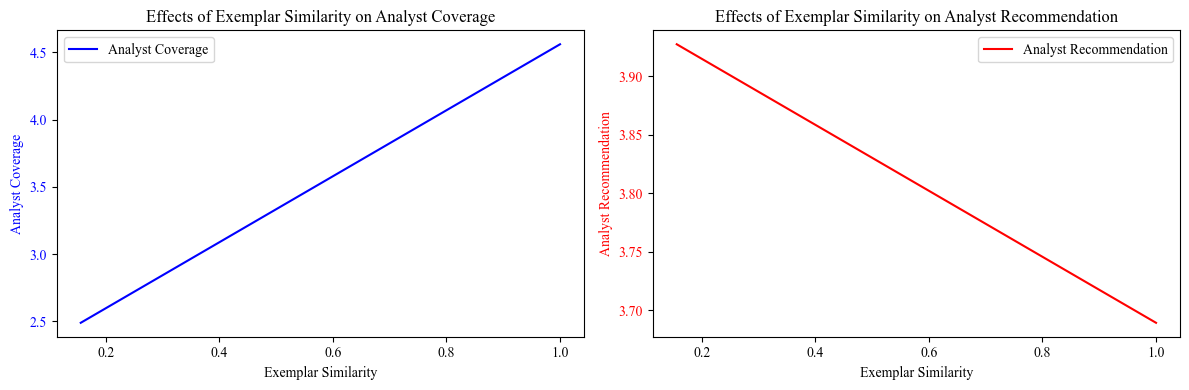

In [36]:

# Create side-by-side plots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot analyst coverage on the first plot
ax1.plot(exemplar_sim_range, predicted_coverage, label='Analyst Coverage', color='blue')
ax1.set_xlabel('Exemplar Similarity')
ax1.set_ylabel('Analyst Coverage', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')
ax1.set_title('Effects of Exemplar Similarity on Analyst Coverage')

# Plot analyst recommendation on the second plot
ax2.plot(exemplar_sim_range, predicted_recommendation, label='Analyst Recommendation', color='red')
ax2.set_xlabel('Exemplar Similarity')
ax2.set_ylabel('Analyst Recommendation', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.legend(loc='upper right')
ax2.set_title('Effects of Exemplar Similarity on Analyst Recommendation')

# Set the title and show the plot
plt.tight_layout()

# Save the figure with a high dpi
plt.savefig("../data/figures/main_effects_plot.png", dpi=900)

# Show the plot
plt.show()


### The plots with confidence intervals

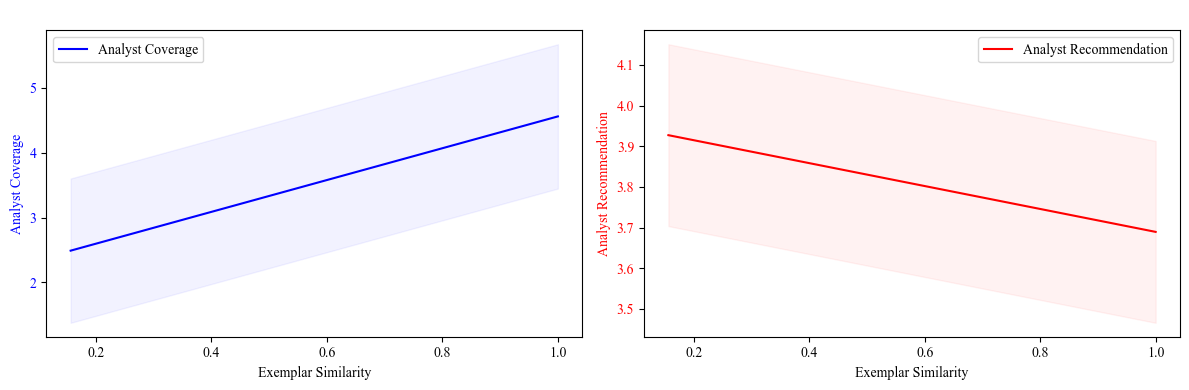

In [37]:
# graphing results with confidence intervals
# Calculate predicted coverage and its confidence intervals
# Calculate predicted coverage and its confidence intervals
res1_exemplar_sim_std = res1.std_errors['Exemplar Similarity']
res2_exemplar_sim_std = res2.std_errors['Exemplar Similarity']

predicted_coverage = []
upper_bound_coverage = []
lower_bound_coverage = []
for sim in exemplar_sim_range:
    ind_vars_mean_df.loc[:, 'Exemplar Similarity'] = sim
    predictions = res1.predict(ind_vars_mean_df.loc[(slice(None), sim), :]).values.mean()
    predicted_coverage.append(predictions)
    upper_bound_coverage.append(predictions + 1.96 * res1_exemplar_sim_std)
    lower_bound_coverage.append(predictions - 1.96 * res1_exemplar_sim_std)

# Calculate predicted recommendation and its confidence intervals
predicted_recommendation = []
upper_bound_recommendation = []
lower_bound_recommendation = []
for sim in exemplar_sim_range:
    ind_vars_mean_df.loc[:, 'Exemplar Similarity'] = sim
    predictions = res2.predict(ind_vars_mean_df.loc[(slice(None), sim), :]).values.mean()
    predicted_recommendation.append(predictions)
    upper_bound_recommendation.append(predictions + 1.96 * res2_exemplar_sim_std)
    lower_bound_recommendation.append(predictions - 1.96 * res2_exemplar_sim_std)

# Create side-by-side plots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot analyst coverage on the first plot along with its confidence intervals
ax1.plot(exemplar_sim_range, predicted_coverage, label='Analyst Coverage', color='blue')
ax1.fill_between(exemplar_sim_range, lower_bound_coverage, upper_bound_coverage, color='blue', alpha=0.05)
ax1.set_xlabel('Exemplar Similarity')
ax1.set_ylabel('Analyst Coverage', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')
ax1.set_title(' ') # Effects of Exemplar Similarity on Analyst Coverage

# Plot analyst recommendation on the second plot along with its confidence intervals
ax2.plot(exemplar_sim_range, predicted_recommendation, label='Analyst Recommendation', color='red')
ax2.fill_between(exemplar_sim_range, lower_bound_recommendation, upper_bound_recommendation, color='red', alpha=0.05)
ax2.set_xlabel('Exemplar Similarity')
ax2.set_ylabel('Analyst Recommendation', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.legend(loc='upper right')
ax2.set_title(' ') # Effects of Exemplar Similarity on Analyst Recommendation


# Set the title and show the plot
plt.tight_layout()

# Save the figure with a high dpi
plt.savefig("../data/figures/main_effects_plot_confidence.png", dpi=900)

# Show the plot
plt.show()


## Effect size for Moderation Models

In [46]:
# Interpreting interaction terms
def calculate_moderated_effects(results, data, iv_name, moderator_name, dv_name, moderator_values, dv_mean):
    # Extract coefficients and standard deviations
    iv_coef = results.params[iv_name]
    interaction_coef = results.params[f'{iv_name} x {moderator_name}']
    iv_std = np.std(data[iv_name])

    for moderator_value in moderator_values:
        # Calculate the effect of a one standard deviation change in IV on DV at the current level of the moderator
        effect_size = iv_coef * iv_std + interaction_coef * iv_std * moderator_value
        data2=data.copy().dropna(subset=[dv_name])
        dv_percentile = 50
        dv_median = np.median(data2[dv_name])
        dv_value_new = dv_median + effect_size
        dv_percentile_new = (np.sum(data2[dv_name] <= dv_value_new) / len(data2)) * 100
        dv_percentile_change = dv_percentile_new - dv_percentile
        print(f"{dv_name} - {iv_name} main effect: {effect_size:.4f}, dv percentile change: {dv_percentile_change:.2f}")


In [47]:
# effect size NUMREC_mean_0_lead sim_firm_ind_naics4_all:
moderator_sd = np.std(reg_data['Category Coherence'])
moderator_mean = np.mean(reg_data['Category Coherence'])
dv_mean = np.mean(reg_data['Analyst Coverage'])
moderator_values = [ moderator_mean - 2*moderator_sd,
                    moderator_mean + 2*moderator_sd]
calculate_moderated_effects(res3, reg_data, 'Exemplar Similarity', 'Category Coherence', 'Analyst Coverage', moderator_values, dv_mean)


Analyst Coverage - Exemplar Similarity main effect: 0.0748, dv percentile change: 0.20
Analyst Coverage - Exemplar Similarity main effect: 0.7732, dv percentile change: 3.38


In [48]:
# effect size NUMREC_mean_0_lead sim_firm_ind_naics4_all:
moderator_sd = np.std(reg_data['Category Coherence'])
moderator_mean = np.mean(reg_data['Category Coherence'])
dv_mean = np.mean(reg_data['Analyst Recoms'])
moderator_values = [ moderator_mean - 2*moderator_sd,
                    moderator_mean + 2*moderator_sd]
calculate_moderated_effects(res4, reg_data, 'Exemplar Similarity', 'Category Coherence', 'Analyst Recoms', moderator_values, dv_mean)


Analyst Recoms - Exemplar Similarity main effect: -0.0150, dv percentile change: -0.94
Analyst Recoms - Exemplar Similarity main effect: -0.0535, dv percentile change: -3.35


In [49]:
# effect size NUMREC_mean_0_lead sim_firm_ind_naics4_all:
moderator_sd = np.std(reg_data['Category Distinctiveness'])
moderator_mean = np.mean(reg_data['Category Distinctiveness'])
dv_mean = np.mean(reg_data['Analyst Coverage'])
moderator_values = [ moderator_mean - 2*moderator_sd,
                    moderator_mean + 2*moderator_sd]
calculate_moderated_effects(res5, reg_data, 'Exemplar Similarity', 'Category Distinctiveness', 'Analyst Coverage', moderator_values, dv_mean)


Analyst Coverage - Exemplar Similarity main effect: -0.2186, dv percentile change: -6.72
Analyst Coverage - Exemplar Similarity main effect: 0.7789, dv percentile change: 3.43


In [50]:
# effect size NUMREC_mean_0_lead sim_firm_ind_naics4_all:
moderator_sd = np.std(reg_data['Category Distinctiveness'])
moderator_mean = np.mean(reg_data['Category Distinctiveness'])
dv_mean = np.mean(reg_data['Analyst Recoms'])
moderator_values = [ moderator_mean - 2*moderator_sd,
                    moderator_mean + 2*moderator_sd]
calculate_moderated_effects(res6, reg_data, 'Exemplar Similarity', 'Category Distinctiveness', 'Analyst Recoms', moderator_values, dv_mean)


Analyst Recoms - Exemplar Similarity main effect: 0.0088, dv percentile change: 0.46
Analyst Recoms - Exemplar Similarity main effect: -0.0685, dv percentile change: -4.18


In [51]:
# effect size NUMREC_mean_0_lead sim_firm_ind_naics4_all:
moderator_sd = np.std(reg_data['Exemplar Typicality'])
moderator_mean = np.mean(reg_data['Exemplar Typicality'])
dv_mean = np.mean(reg_data['Analyst Coverage'])
moderator_values = [ moderator_mean - 2*moderator_sd,
                    moderator_mean + 2*moderator_sd]
calculate_moderated_effects(res7, reg_data, 'Exemplar Similarity', 'Exemplar Typicality', 'Analyst Coverage', moderator_values, dv_mean)


Analyst Coverage - Exemplar Similarity main effect: 0.1903, dv percentile change: 0.70
Analyst Coverage - Exemplar Similarity main effect: 0.4997, dv percentile change: 1.92


In [52]:
# effect size NUMREC_mean_0_lead sim_firm_ind_naics4_all:
moderator_sd = np.std(reg_data['Exemplar Typicality'])
moderator_mean = np.mean(reg_data['Exemplar Typicality'])
dv_mean = np.mean(reg_data['Analyst Recoms'])
moderator_values = [ moderator_mean - 2*moderator_sd,
                    moderator_mean + 2*moderator_sd]
calculate_moderated_effects(res8, reg_data, 'Exemplar Similarity', 'Exemplar Typicality', 'Analyst Recoms', moderator_values, dv_mean)


Analyst Recoms - Exemplar Similarity main effect: -0.0201, dv percentile change: -1.21
Analyst Recoms - Exemplar Similarity main effect: -0.0625, dv percentile change: -3.76


## Plotting Moderation Effects

In [48]:
# Graphing interactions
# Create a function to create the moderation plot
def create_moderation_plot(ax, reg_data,res, moderator_var, interation_term,  title, x_label, y_label ):
    coef = res.params
    cov_matrix = res.cov

    m_mean = reg_data[moderator_var].mean()
    m_std = reg_data[moderator_var].std()

    levels = ['Very low', 'Low', 'Mean', 'High', 'Very high']
    values = [m_mean - 2 * m_std,
              m_mean - m_std,
              m_mean,
              m_mean + m_std,
              m_mean + 2 * m_std]


    coefficients = []
    for value in values:
        coef_value = res.params['Exemplar Similarity'] + res.params[interation_term] * value
        coefficients.append(coef_value)

    ax.bar(levels, coefficients)
    ax.set_xlabel(x_label, fontsize=16)
    ax.set_ylabel(y_label, fontsize=16)

    standard_errors = []
    # for value in values:
    #     se = np.sqrt(res.std_errors['exemplar_sim_naics4']**2 + (value * res.std_errors[interation_term])**2)
    #     standard_errors.append(se)

    for value in values:
        # Create a derivative vector
        derivative = np.zeros(len(coef))
        idx_exemplar_sim_naics4 = coef.index.get_loc('Exemplar Similarity')
        idx_interaction_term = coef.index.get_loc(interation_term)

        derivative[idx_exemplar_sim_naics4] = 1
        derivative[idx_interaction_term] = value

        # Calculate the variance of the combined effect using the delta method
        var = derivative.T @ cov_matrix @ derivative

        # Calculate the standard error
        se = np.sqrt(var)
        standard_errors.append(se)

    #ax.errorbar(levels, coefficients, yerr=standard_errors, fmt='o', capsize=2,  capthick=1)
    ax.errorbar(levels, coefficients, yerr = standard_errors, fmt='none',  color = 'black', capsize = 5)
    ax.set_title(title, fontsize=18)

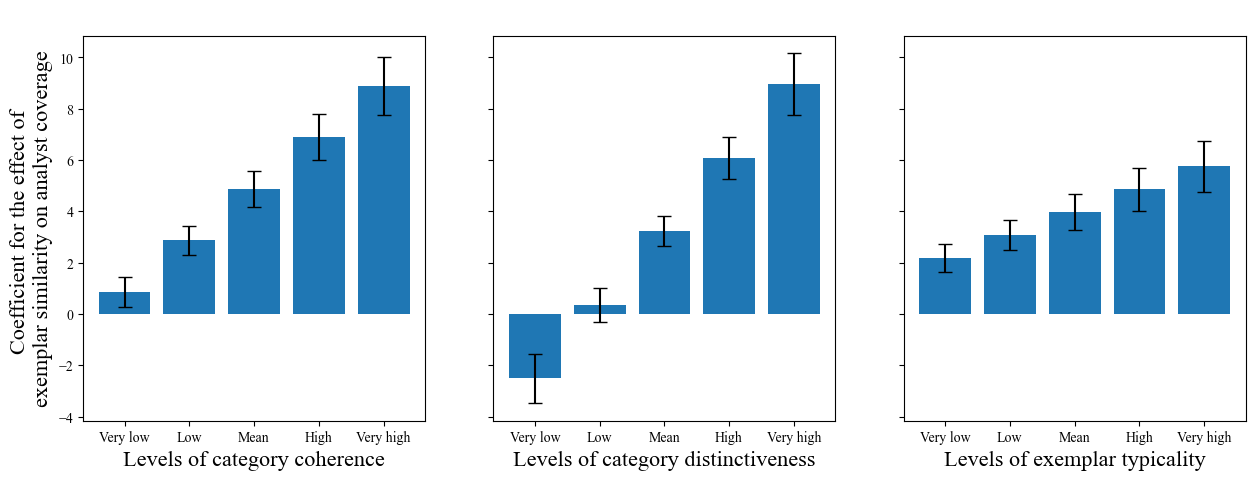

In [50]:
# Create a 1x3 grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Call the function for each moderation model
create_moderation_plot(axes[0], reg_data, res3, 'Category Coherence', 'Exemplar Similarity x Category Coherence', ' ', 'Levels of category coherence', 'Coefficient for the effect of \nexemplar similarity on analyst coverage')
create_moderation_plot(axes[1], reg_data, res5, 'Category Distinctiveness', 'Exemplar Similarity x Category Distinctiveness', ' ', 'Levels of category distinctiveness', '')
create_moderation_plot(axes[2], reg_data, res7, 'Exemplar Typicality','Exemplar Similarity x Exemplar Typicality',' ', 'Levels of exemplar typicality', '')

# Save the figure with a high dpi
plt.savefig("../data/figures/interactions_coverage.png", dpi=900)

plt.show()


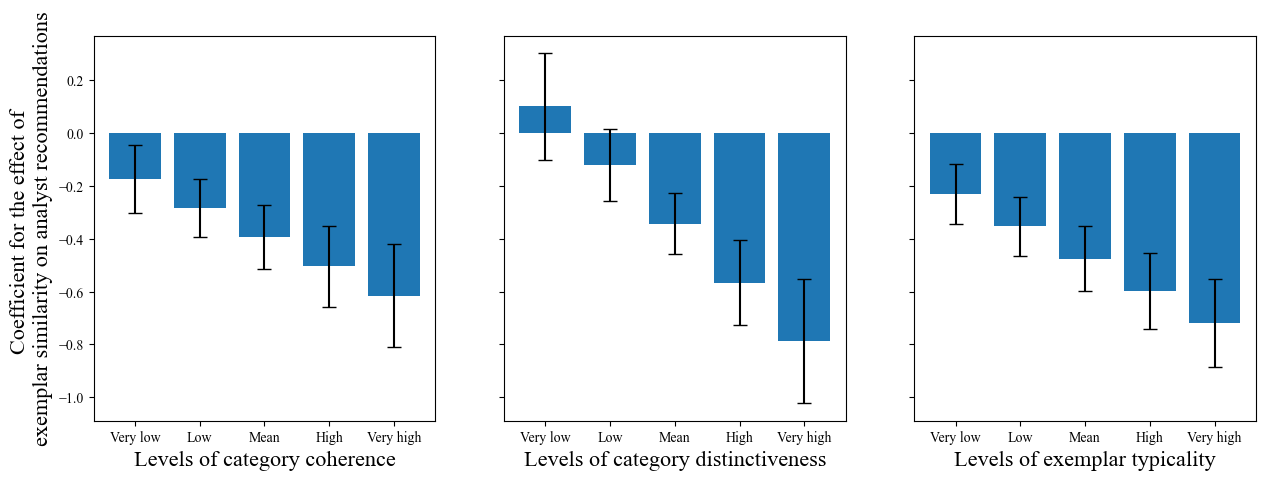

In [51]:
# Create a 1x3 grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Call the function for each moderation model
create_moderation_plot(axes[0], reg_data, res4, 'Category Coherence', 'Exemplar Similarity x Category Coherence', ' ', 'Levels of category coherence', 'Coefficient for the effect of \nexemplar similarity on analyst recommendations')
create_moderation_plot(axes[1], reg_data, res6, 'Category Distinctiveness', 'Exemplar Similarity x Category Distinctiveness', ' ', 'Levels of category distinctiveness', '')
create_moderation_plot(axes[2], reg_data, res8, 'Exemplar Typicality','Exemplar Similarity x Exemplar Typicality',' ', 'Levels of exemplar typicality', '')

# Save the figure with a high dpi
plt.savefig("../data/figures/interactions_recommendations.png", dpi=900)

plt.show()


# Supplementary analysis

## Effect of exemplar similarity on firm performance (EPS)

In [57]:
dv_var = 'EPS'
reg_data = reg_data.reset_index().sort_values(by=['GVKEY', 'year'])
reg_data['year_temp'] = reg_data['year']
reg_data = reg_data.set_index(['GVKEY', 'year'])

In [58]:

# Create lags and leads
for lead in range(1, 9):
    reg_data[f'f{".f" * (lead-1)}.{dv_var}'] = reg_data.groupby('GVKEY')[dv_var].shift(-lead)
    reg_data[f'f{".f" * (lead-1)}.year'] = reg_data.groupby('GVKEY')['year_temp'].shift(-lead) - lead
    reg_data[f'f{".f" * (lead-1)}.year_diff'] = reg_data[f'f{".f" * (lead-1)}.year'] - reg_data['year_temp']
    reg_data[f'f{".f" * (lead-1)}.{dv_var}'].where(reg_data[f'f{".f" * (lead-1)}.year_diff'] <= (lead+1), inplace=True)

In [59]:
reg_data

meanrec  numrec  meanrec_mean  numrec_mean  meanrec_descend  \
GVKEY  year                                                                
1004   1999     1.50     8.0      1.585000     7.900000             4.50   
1013   1997      NaN     NaN           NaN          NaN              NaN   
       1998      NaN     NaN           NaN          NaN              NaN   
       1999      NaN     NaN           NaN          NaN              NaN   
       2000      NaN     NaN           NaN          NaN              NaN   
...              ...     ...           ...          ...              ...   
331856 2020     1.57     7.0      1.543636     4.363636             4.43   
332115 2019     1.50     2.0      1.571429     1.857143             4.50   
       2020     1.75     4.0      1.712727     3.636364             4.25   
345556 2020     2.00     2.0      2.000000     2.000000             4.00   
345980 2020      NaN     NaN           NaN          NaN              NaN   

             sim_5nearest  sim_10nearest  sim_20nearest  meanrec_mean_descend  \
GVKEY  year                                                                     
1004   1999           NaN            NaN            NaN              4.415000   
1013   1997      0.918272       0.912448       0.902568                   NaN   
       1998      0.915514       0.909378       0.900920                   NaN   
       1999      0.842644       0.830457       0.811545                   NaN   
       2000           NaN            NaN            NaN                   NaN   
...                   ...            ...            ...                   ...   
331856 2020      0.884478       0.876896       0.866198              4.456364   
332115 2019      0.947141       0.941594       0.935796              4.428571   
       2020      0.943103       0.938735       0.930405              4.287273   
345556 2020      0.966117       0.963060       0.958640              4.000000   
345980 2020      0.882485       0.864037       0.846568                   NaN   

             numrec_mean_0  ...  f.f.f.f.f.f.EPS  f.f.f.f.f.f.year  \
GVKEY  year                 ...                                      
1004   1999       7.900000  ...              NaN               NaN   
1013   1997       0.000000  ...        -0.095091            1997.0   
       1998       0.000000  ...         0.020244            1998.0   
       1999       0.000000  ...         0.950215            1999.0   
       2000       0.000000  ...        -4.909938            2003.0   
...                    ...  ...              ...               ...   
331856 2020       4.363636  ...              NaN               NaN   
332115 2019       1.857143  ...              NaN               NaN   
       2020       3.636364  ...              NaN               NaN   
345556 2020       2.000000  ...              NaN               NaN   
345980 2020       0.000000  ...              NaN               NaN   

             f.f.f.f.f.f.year_diff  f.f.f.f.f.f.f.EPS  f.f.f.f.f.f.f.year  \
GVKEY  year                                                                 
1004   1999                    NaN                NaN                 NaN   
1013   1997                    0.0           0.020244              1997.0   
       1998                    0.0           0.950215              1998.0   
       1999                    0.0          -4.909938              2002.0   
       2000                    3.0                NaN                 NaN   
...                            ...                ...                 ...   
331856 2020                    NaN                NaN                 NaN   
332115 2019                    NaN                NaN                 NaN   
       2020                    NaN                NaN                 NaN   
345556 2020                    NaN                NaN                 NaN   
345980 2020                    NaN                NaN                 NaN   

             f.f.f.f.f.f.f.year_diff  f.f.f.f.f.f.f.f.EPS

In [60]:

# List of regressors
regressors = iv + moderators + controls

# Initialize lists to hold coefficients and standard errors
coefficients = []
std_errors = []

reg_results = []

# Run regressions
for lead in range(1, 6):
    # Define condition
    condition = (reg_data[f'f{".f" * (2)}.{dv_var}'].notna())

    # Filter DataFrame based on condition
    df_filtered = reg_data[condition]

    # Define dependent variable
    dep_var = f'f{".f" * (lead-1)}.{dv_var}'

    # Construct formula for regression
    model = PanelOLS(df_filtered[dep_var], df_filtered[regressors], entity_effects=True)
    res = model.fit(cov_type='clustered', cluster_entity=True)
    reg_results.append(res)

    # Append coefficient and standard error for 'exemplar_sim_naics4'
    coefficients.append(res.params['Exemplar Similarity'])
    std_errors.append(res.std_errors['Exemplar Similarity'])

    print(res)


                          PanelOLS Estimation Summary                           
Dep. Variable:                  f.EPS   R-squared:                        0.0871
Estimator:                   PanelOLS   R-squared (Between):              0.3792
No. Observations:               29034   R-squared (Within):               0.0871
Date:                Tue, Jun 20 2023   R-squared (Overall):              0.2790
Time:                        14:50:39   Log-likelihood                -4.962e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      92.838
Entities:                        4669   P-value                           0.0000
Avg Obs:                       6.2185   Distribution:                F(25,24340)
Min Obs:                       1.0000                                           
Max Obs:                       22.000   F-statistic (robust):             21.211
                            

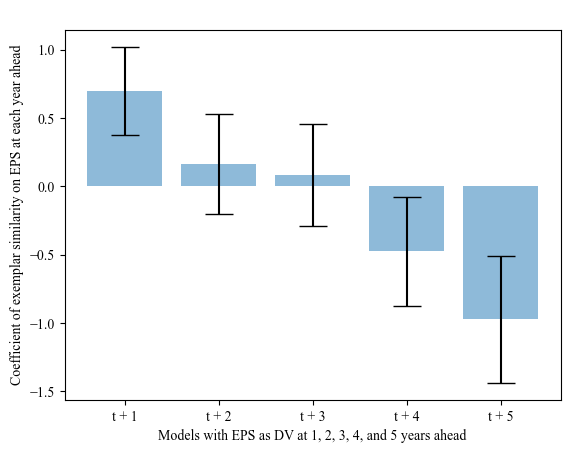

In [61]:

# Create bar chart
x = range(1, 6)
labels = [f't + {i}' for i in x]
plt.bar(x, coefficients, yerr=std_errors, align='center', alpha=0.5, ecolor='black', capsize=10)
plt.xlabel('Models with EPS as DV at 1, 2, 3, 4, and 5 years ahead')
plt.ylabel('Coefficient of exemplar similarity on EPS at each year ahead')
plt.title(' ') # Long term effect of exemplar similarity on firm performance (EPS)
plt.xticks(x, labels)
plt.savefig("../data/figures/long_term_effect_performance.png", dpi=900)
plt.show()

In [64]:
table_eps = create_table(reg_results[0], reg_results[1], reg_results[2], reg_results[3], reg_results[4])
table_eps.T.to_csv('../data/tables/longterm_eps.csv')

In [102]:
# Regressions with interaction terms - analyst coverage and category coherence
interaction_term = 'Exemplar Similarity x Firm Typicality'
reg_data[interaction_term] = reg_data['Exemplar Similarity'] * reg_data['Firm Typicality']
regressors = iv + moderators + [interaction_term] + controls

model_eps_1 = PanelOLS(reg_data['f.EPS'], reg_data[regressors], entity_effects=True)
res_eps1 = model_eps_1.fit(cov_type='clustered', cluster_entity=True)

model_eps_2 = PanelOLS(reg_data['f.f.EPS'], reg_data[regressors], entity_effects=True)
res_eps2 = model_eps_2.fit(cov_type='clustered', cluster_entity=True)

model_eps_3 = PanelOLS(reg_data['f.f.f.EPS'], reg_data[regressors], entity_effects=True)
res_eps3 = model_eps_3.fit(cov_type='clustered', cluster_entity=True)


In [104]:
table = create_table(res_eps1, res_eps2, res_eps3)
table.T.to_csv('../data/tables/eps_typicality_moderation.csv')


## Effects of exemplar similarity based on Exemplar EPS

In [65]:
from scipy import stats

In [68]:
group1 = data.dropna(subset=['EPS_wins_1', f'exemplar_{ind_col}'])[data[f'exemplar_{ind_col}'] == 0]['EPS_wins_1']
group2 = data.dropna(subset=['EPS_wins_1', f'exemplar_{ind_col}'])[data[f'exemplar_{ind_col}'] == 1]['EPS_wins_1']

t_stat, p_val = stats.ttest_ind(group1, group2, equal_var=False) # Welch's t-test that does not assume equal population variance

print(f'The t-statistic is: {t_stat}, and the p-value is: {p_val}')

The t-statistic is: -44.52179800103767, and the p-value is: 0.0


### Exemplar similarity when EPS Diff above and below mean

In [69]:
reg_data['EPS Diff'] = reg_data['Exemplar EPS'] - reg_data['EPS']


In [70]:
eps_diff_median = reg_data['EPS Diff'].median()

In [71]:
regressors = iv + moderators + controls

In [72]:

# Create two dataframes based on the condition
reg_data_above_mean = reg_data[reg_data['EPS Diff'] > eps_diff_median].dropna(subset=regressors)
reg_data_below_mean = reg_data[reg_data['EPS Diff'] <= eps_diff_median].dropna(subset=regressors)


In [73]:
reg_data_below_mean

meanrec  numrec  meanrec_mean  numrec_mean  meanrec_descend  \
GVKEY  year                                                                
1013   1998      NaN     NaN           NaN          NaN              NaN   
       2002      NaN     NaN           NaN          NaN              NaN   
       2003      NaN     NaN           NaN          NaN              NaN   
       2004      NaN     NaN           NaN          NaN              NaN   
       2005     2.29    21.0      2.268571    19.000000             3.71   
...              ...     ...           ...          ...              ...   
296866 2019      NaN     NaN           NaN          NaN              NaN   
317264 2020     2.29     7.0      2.150000     6.363636             3.71   
318728 2020     2.33    12.0      2.228182    13.545455             3.67   
331856 2020     1.57     7.0      1.543636     4.363636             4.43   
332115 2020     1.75     4.0      1.712727     3.636364             4.25   

             sim_5nearest  sim_10nearest  sim_20nearest  meanrec_mean_descend  \
GVKEY  year                                                                     
1013   1998      0.915514       0.909378       0.900920                   NaN   
       2002      0.928712       0.923030       0.915065                   NaN   
       2003      0.961816       0.953949       0.944272                   NaN   
       2004      0.955013       0.949749       0.942155                   NaN   
       2005      0.941353       0.934534       0.925970              3.731429   
...                   ...            ...            ...                   ...   
296866 2019      0.803151       0.794620       0.786231                   NaN   
317264 2020      0.961326       0.919593       0.846115              3.850000   
318728 2020      0.949628       0.944283       0.938299              3.771818   
331856 2020      0.884478       0.876896       0.866198              4.456364   
332115 2020      0.943103       0.938735       0.930405              4.287273   

             numrec_mean_0  ...  f.f.f.f.f.f.year  f.f.f.f.f.f.year_diff  \
GVKEY  year                 ...                                            
1013   1998       0.000000  ...            1998.0                    0.0   
       2002       0.000000  ...               NaN                    NaN   
       2003       0.000000  ...               NaN                    NaN   
       2004       0.000000  ...               NaN                    NaN   
       2005      19.000000  ...               NaN                    NaN   
...                    ...  ...               ...                    ...   
296866 2019       0.000000  ...               NaN                    NaN   
317264 2020       6.363636  ...               NaN                    NaN   
318728 2020      13.545455  ...               NaN                    NaN   
331856 2020       4.363636  ...               NaN                    NaN   
332115 2020       3.636364  ...               NaN                    NaN   

             f.f.f.f.f.f.f.EPS  f.f.f.f.f.f.f.year  f.f.f.f.f.f.f.year_diff  \
GVKEY  year                                                                   
1013   1998           0.950215              1998.0                      0.0   
       2002                NaN                 NaN                      NaN   
       2003                NaN                 NaN                      NaN   
       2004                NaN                 NaN                      NaN   
       2005                NaN                 NaN                      NaN   
...                        ...                 ...                      ...   
296866 2019                NaN                 NaN                      NaN   
317264 2020                NaN                 NaN                      NaN   
318728 2020                NaN                 NaN                      NaN   
331856 2020                NaN                 NaN                      NaN   
332115 2020                NaN   

In [74]:

# Run the regression model for 'Exemplar EPS' above its mean
model_above_mean = PanelOLS(reg_data_above_mean['Analyst Recoms'], reg_data_above_mean[regressors], entity_effects=True)
res_above_mean = model_above_mean.fit(cov_type='clustered', cluster_entity=True)


In [75]:

# Run the regression model for 'Exemplar EPS' below or equal to its mean
model_below_mean = PanelOLS(reg_data_below_mean['Analyst Recoms'], reg_data_below_mean[regressors], entity_effects=True)
res_below_mean = model_below_mean.fit(cov_type='clustered', cluster_entity=True)


In [76]:

# Print the results
res_above_mean


Dep. Variable:,Analyst Recoms,R-squared:,0.0531
Estimator:,PanelOLS,R-squared (Between):,0.0057
No. Observations:,14899,R-squared (Within):,0.0531
Date:,"Tue, Jun 20 2023",R-squared (Overall):,0.0306
Time:,15:07:05,Log-likelihood,-5099.3
Cov. Estimator:,Clustered,,
,,F-statistic:,23.223
Entities:,4512,P-value,0.0000
Avg Obs:,3.3021,Distribution:,"F(25,10362)"
Min Obs:,1.0000,,
Max Obs:,19.000,F-statistic (robust):,14.217


In [77]:
res_below_mean

Dep. Variable:,Analyst Recoms,R-squared:,0.0573
Estimator:,PanelOLS,R-squared (Between):,0.0302
No. Observations:,15789,R-squared (Within):,0.0573
Date:,"Tue, Jun 20 2023",R-squared (Overall):,0.0428
Time:,15:07:05,Log-likelihood,-5043.0
Cov. Estimator:,Clustered,,
,,F-statistic:,27.365
Entities:,4517,P-value,0.0000
Avg Obs:,3.4955,Distribution:,"F(25,11247)"
Min Obs:,1.0000,,
Max Obs:,23.000,F-statistic (robust):,16.161


In [78]:
table_eps = create_table(res_above_mean, res_below_mean)
table_eps.T.to_csv('../data/tables/exemplar_eps_moderation.csv')

### Effects of exemplar similarity for different levels of EPS difference

In [159]:
regressors = iv + moderators + controls

In [210]:
def plot_coefficients(df, cutoffs):
    # Calculate the percentiles of 'EPS Diff' in the dataframe
    percentiles = np.nanpercentile(df['EPS Diff'], cutoffs)

    # Create dataframes based on the conditions
    samples = []
    for i in range(len(percentiles)):
        if i == 0:
            samples.append(df[df['EPS Diff'] <= percentiles[i]])
        else:
            samples.append(df[(df['EPS Diff'] > percentiles[i-1]) & (df['EPS Diff'] <= percentiles[i])])
    samples.append(df[df['EPS Diff'] > percentiles[-1]])

    # Run the regression model for each sample and store the coefficients and standard errors
    results = []
    reg_res = []
    for sample in samples:
        model = PanelOLS(sample['Analyst Recoms'], sample[regressors], entity_effects=False)
        res = model.fit(cov_type='clustered', cluster_entity=True)
        coef = res.params['Exemplar Similarity']
        std_err = res.std_errors['Exemplar Similarity']
        results.append((coef, std_err))
        reg_res.append(res)

    # Plot the coefficients with standard error as whiskers
    coefs, errs = zip(*results)
    plt.errorbar(['Q'+str(i+1) for i in range(len(samples))], coefs, yerr=errs, fmt='o')
    plt.xlabel('Different quartiles of the distribution of the \ndifference between the exemplar EPS and the focal firm EPS\nQ1: EPS difference below 25 percentile\nQ2: EPS difference between 25 and 50 percentile\nQ3: EPS difference between 50 and 75 percentile\nQ4: EPS difference above 75 percentile')
    plt.ylabel('Coefficient of exemplar similarity on analyst recommendations')
    plt.tight_layout()
    plt.savefig("../data/figures/eps_diff_moderation.png", dpi=900)
    plt.show()

    return reg_res

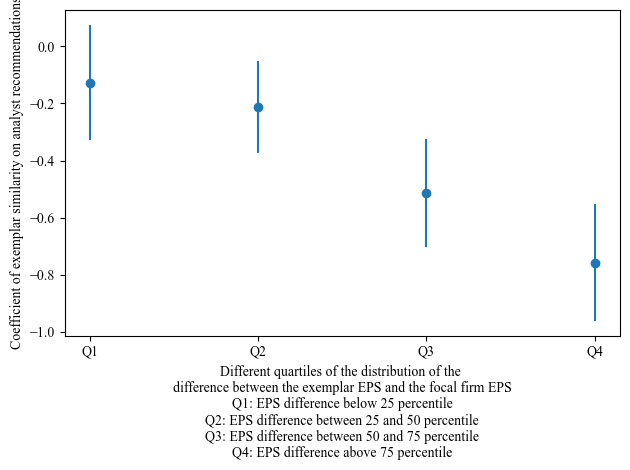

In [211]:
reg_res = plot_coefficients(reg_data, [25, 50, 75])


In [212]:
table_eps_4 = create_table(reg_res[0], reg_res[1], reg_res[2], reg_res[3])
table_eps_4.T.to_csv('../data/tables/eps_diff_moderation_quartiles.csv')

## Moderation Effects of Category Instability

In [79]:
# Regressions with interaction terms - analyst coverage and category coherence
interaction_term = 'Exemplar Similarity x Category Instability'
reg_data[interaction_term] = reg_data['Exemplar Similarity'] * reg_data['Category Instability']
regressors = iv + moderators + [interaction_term] + controls

model9 = PanelOLS(reg_data['Analyst Coverage'], reg_data[regressors], entity_effects=True)
res9 = model9.fit(cov_type='clustered', cluster_entity=True)
res9


Dep. Variable:,Analyst Coverage,R-squared:,0.1190
Estimator:,PanelOLS,R-squared (Between):,0.2005
No. Observations:,46786,R-squared (Within):,0.1190
Date:,"Tue, Jun 20 2023",R-squared (Overall):,0.1775
Time:,15:21:52,Log-likelihood,-1.06e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,203.50
Entities:,7603,P-value,0.0000
Avg Obs:,6.1536,Distribution:,"F(26,39157)"
Min Obs:,1.0000,,
Max Obs:,25.000,F-statistic (robust):,32.467


In [80]:

model10 = PanelOLS(reg_data['Analyst Recoms'], reg_data[regressors], entity_effects=True)
res10 = model10.fit(cov_type='clustered', cluster_entity=True)
res10

Dep. Variable:,Analyst Recoms,R-squared:,0.0526
Estimator:,PanelOLS,R-squared (Between):,0.0300
No. Observations:,30688,R-squared (Within):,0.0526
Date:,"Tue, Jun 20 2023",R-squared (Overall):,0.0413
Time:,15:21:53,Log-likelihood,-1.268e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,52.719
Entities:,5975,P-value,0.0000
Avg Obs:,5.1361,Distribution:,"F(26,24687)"
Min Obs:,1.0000,,
Max Obs:,25.000,F-statistic (robust):,27.068


In [82]:
table_instability = create_table(res9)
table_instability.T.to_csv('../data/tables/instability_moderation.csv')

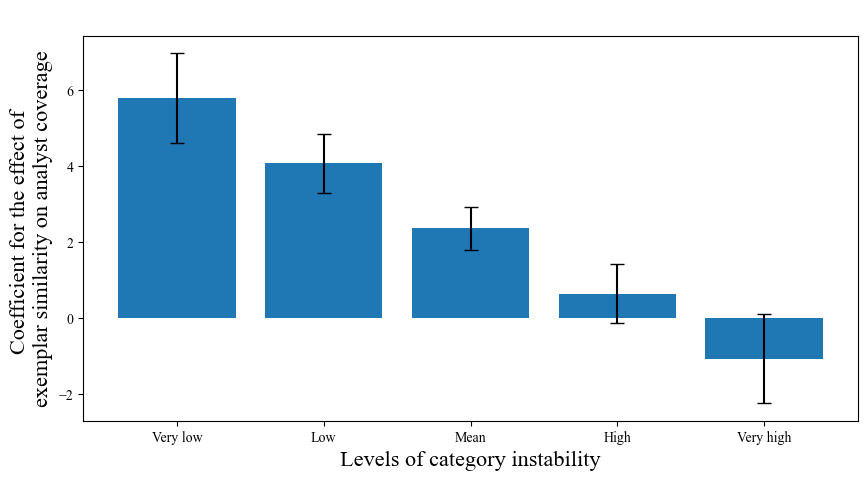

In [56]:

# Create a 1x3 grid of subplots
fig, axes = plt.subplots(1, 1, figsize=(10, 5), sharey=False)

# Call the function for each moderation model
create_moderation_plot(axes, reg_data, res9, 'Category Instability', 'Exemplar Similarity x Category Instability', ' ', 'Levels of category instability', 'Coefficient for the effect of \nexemplar similarity on analyst coverage')
#create_moderation_plot(axes[1], reg_data, res10, 'Category Instability', 'Exemplar Similarity x Category Instability', ' ', 'Levels of category instability', 'Coefficient for the effect of exemplar similarity on analyst recommendations')

# Save the figure with a high dpi
plt.savefig("../data/figures/category_change_moderation.png", dpi=900)

plt.show()